# **Classificazione dei prodotti di Scattering Elettrone-Protone**

Confronto tra diversi *modelli* di Machine Learning per la **classificazione** di particelle prodotte durante uno *scattering inelastico elettrone-protone*, basato sulla risposta di sei diversi rilevatori.

I dati utilizzati sono il prodotto di una simulazione di scattering mediante la piattaforma *[GEANT4](https://geant4.web.cern.ch/)*. Il DataSet è reperibile su *[Kaggle](https://www.kaggle.com/datasets/naharrison/particle-identification-from-detector-responses)*.

## **Prima Parte: Esplorazione del DataSet**

Importo i moduli di interesse:

In [90]:
# Analisi Esplorativa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import (
    SelectKBest,
    mutual_info_regression,
    mutual_info_classif)

Carico il dataset:

In [91]:
df = pd.read_csv("..\GEANT4_Simulation.csv")
df.head()

#id significato: positroni (-11), pioni (211), kaoni (321), e protoni (2212)
#p è la quantità di moto (GeV/c)
#theta è un angolo (rad)
#beta è la velocità relativistica  (v/c) (adimensionale) 
#nphe è il numero di fotoelettroni
#ein è l'energia in ingresso (GeV)
#eout è l'energia in uscita (GeV)

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


Rendo più leggibile il dataset e rinomino la colonna dell'id e le particelle usanod un mappamento mediante dizionario (link per aggiungere qualcosa in documentazione https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html)

In [3]:
dictParticelle = { -11 : 'positrone',
                  211 : 'pione',
                  321 : 'kaone',
                  2212 : 'protone'}

In [92]:
# Rinomino
df.rename(columns={'id' : 'particella'}, inplace=True)
df.rename(columns={'nphe' : 'elettroni'}, inplace=True)
# Mappo
df['particella'] = df['particella'].map(dictParticelle)


In [5]:
df.head(100)

,particella,p,theta,beta,elettroni,ein,eout
0,pione,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,pione,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,protone,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,pione,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,protone,2.123290,0.337332,0.908652,0,0.034379,0.049256
...,...,...,...,...,...,...,...
95,protone,1.360950,0.147539,0.824000,0,0.000000,0.000000
96,pione,1.346610,0.241262,0.984269,0,0.251499,0.095903
97,protone,0.993210,0.755494,0.733585,0,0.000000,0.000000
98,pione,0.596323,0.722834,0.971532,0,0.000000,0.000000


Controllo se ci sono dei dati mancanti e le dimensioni del df:

uso pandas.DataFrame.isnull() : https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html
e pandas.DataFrame.sum() : https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html

In [93]:
print(df.isnull().sum())
print("-"*20)
print(df.shape)

particella    0
p             0
theta         0
beta          0
elettroni     0
ein           0
eout          0
dtype: int64
--------------------
(5000000, 7)


Ci sono cinque milioni di dati e nessuno mancante. Osservo ora in che proporzione stanno i prodotti tra di loro

pione        56.13666
protone      38.91698
kaone         4.64942
positrone     0.29694
Name: particella, dtype: float64


<AxesSubplot:xlabel='particella', ylabel='count'>

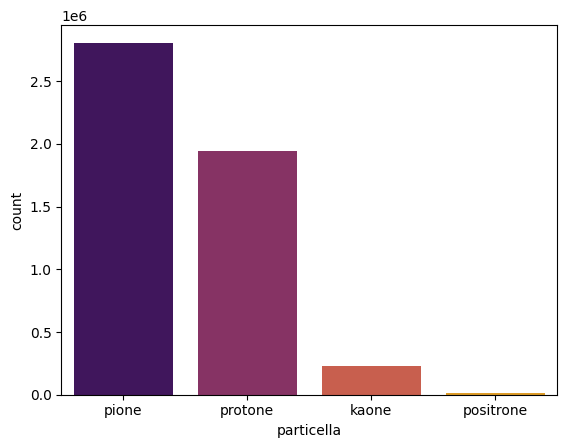

In [94]:
print(df['particella'].value_counts(normalize = True) * 100)

sns.countplot(x = df['particella'], palette='inferno')


Osservo che prodotti di positroni e kaoni sono rispettivamente solo un 4% circa e lo 0.3%: sono sottorappresentate. Di regola dovrei ridurre pioni e proton i kaoni, per rendere tutte le particelle equirappresentate. (undersampling)

https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html

In [95]:
sp = df['particella'].value_counts() # sp = Serie Particelle
print(sp)

pione        2806833
protone      1945849
kaone         232471
positrone      14847
Name: particella, dtype: int64


In [96]:
from imblearn.under_sampling import RandomUnderSampler

In [98]:
# Resampling - undersampling
x = pd.DataFrame(df)
y = x['particella']

undersample = RandomUnderSampler(sampling_strategy='not minority')
df_us, _ = undersample.fit_resample(x, y)


kaone        14847
pione        14847
positrone    14847
protone      14847
Name: particella, dtype: int64


<AxesSubplot:xlabel='particella', ylabel='count'>

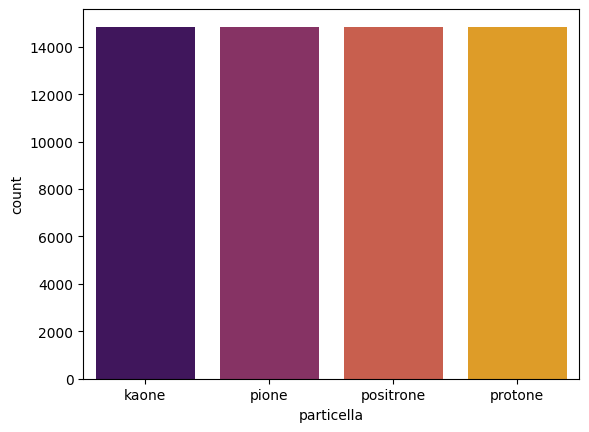

In [99]:
print(df_us['particella'].value_counts())

sns.countplot(x = df_us['particella'], palette='inferno')

Ora che il dataset è bilanciato, vedo se le Features sono correlate: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html

<AxesSubplot:>

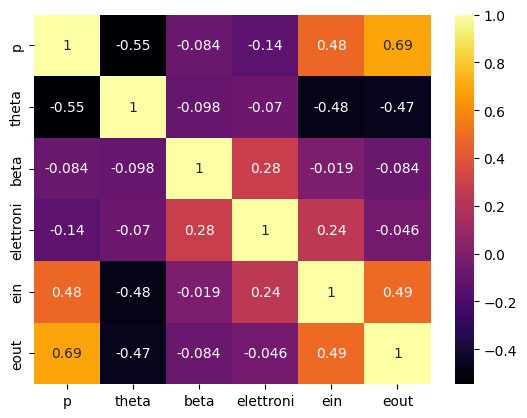

In [101]:
sns.heatmap(df_us.corr(method="spearman"), annot=True, cmap="inferno")

L'unica correlazione che posso vedere è tra la quantità di moto e ovviamente l'energia in uscita legata questa alla sua energia cinetica, per il resto m fatt cazz.

Osservando il dataset ipotizzo che il rilevatore circa gli elettroni è stato inneficente (segna spesso 0), faccio un controllo su questea feature e nel caso elimino la colonna prima dell'addestramento.

In [114]:
df_us.head()

,particella,p,theta,beta,elettroni,ein,eout
0,kaone,2.41306,0.275914,0.973231,0,0.059419,0.064454
1,kaone,1.12810,0.149704,0.906587,0,0.030579,0.052644
2,kaone,1.96368,0.207054,0.972844,0,0.000000,0.049760
3,kaone,1.32235,0.356545,0.927908,0,0.178027,0.033280
4,kaone,1.83185,0.154715,0.954466,0,0.027970,0.041611


In [115]:
flop = df_us['elettroni'].value_counts(normalize = True)
print('Il rilevatore manca il segnale il {volte:.2%} delle volte'.format(volte=flop[0]))

Il rilevatore manca il segnale il 85.80% delle volte


A sto punto lo zappo brutalmente

In [116]:
df_us.drop(columns = ['elettroni'], inplace=True)
df_us.head()

,particella,p,theta,beta,ein,eout
0,kaone,2.41306,0.275914,0.973231,0.059419,0.064454
1,kaone,1.12810,0.149704,0.906587,0.030579,0.052644
2,kaone,1.96368,0.207054,0.972844,0.000000,0.049760
3,kaone,1.32235,0.356545,0.927908,0.178027,0.033280
4,kaone,1.83185,0.154715,0.954466,0.027970,0.041611


Così perchè non so che fare vedo come cambia la velocità con l'impulso, ovviamente mi aspetto che tendano tutti ad 1 forse... 

From the figure above the different particle types can be seen. This is a so-called Time-Of-Flight plot, where on the y-axis is the relativistic velocity beta = v/c, where v is the velocity and c the speed of light and on the x-axis is the momentum of the particle. Here Monte Carlo information is used to visualize the different particle behaviour due to the different particle masses. Pions which are the lightest hadrons get closer to the limiting speed of light, i.e. beta approximately unity, where the heavier kaons and protons still have smaller velocities. Particles can be in particular separated by their different mass.

commento preso da: 
https://www.kaggle.com/code/mkkoehler/particle-id-using-a-couple-of-ml-algorithms

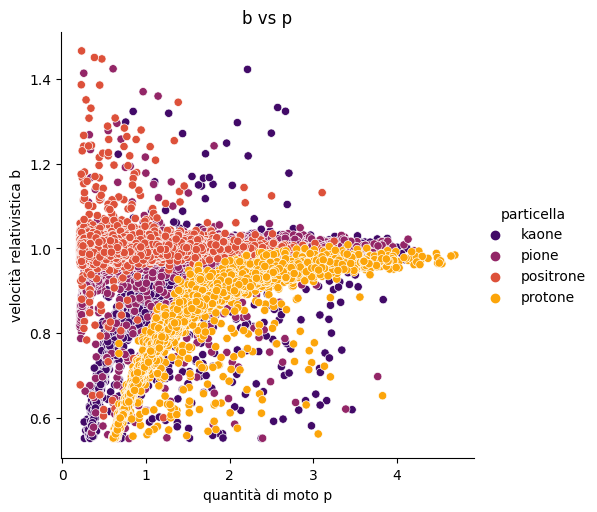

In [102]:
# uso fig e non direttamente replot così modifico la figura perchè replot resituisce un axis-object
ax = sns.relplot(
    data=df_us, #riduco il dataset se no mi esplode il pc
    x='p',
    y='beta',
    hue='particella',
    palette = 'inferno'
    )

ax.set(xlabel='quantità di moto p', ylabel='velocità relativistica b', title = "b vs p")
plt.show()

Mi creo una funzione che mi faccia vedere visivamente come le particelle si distribuiscono rispetto le loro feature
e uso uno "kernel density estimition plot KDE" che è più facile da interpretare. "Stima kernel di densità" (https://it.wikipedia.org/wiki/Stima_kernel_di_densit%C3%A0). Si può usare anche displot e come parametro kind = "kde"

In [117]:
def distribuzione(colonna, target = 'particella'):
    for tag in df_us[target].unique(): #Plotto un grafico per ogni tipo di particella
        sns.kdeplot(data=df_us[df_us[target] == tag][colonna], label = tag)
    
    sns.kdeplot(data=df_us[colonna],label = "Tutte", fill = True, palette = 'inferno')
    plt.legend()

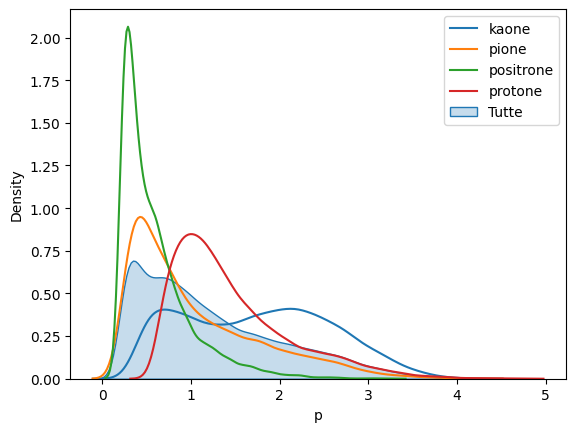

In [104]:
distribuzione('p')

## **Seconda Parte: Scelta del modello e Addestramento**

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay




## **Classificazione**
Random forests is a set of multiple decision trees.
Deep decision trees may suffer from overfitting, but random forests prevents overfitting by creating trees on random subsets.
Decision trees are computationally faster.
Random forests is difficult to interpret, while a decision tree is easily interpretable and can be converted to rules.

In [124]:
x = df_us.drop(columns = ['particella']) # Le features ovviamente sono tutte quelle tranne il nome della particella
y = df_us['particella'] #label

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 2022, train_size = 0.7)

### **Albero Decisionale**

In [125]:
%%time

dt_class = DecisionTreeClassifier()
dt_class.fit(x_train, y_train)
y_pred_dt = dt_class.predict(x_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)

print('Accuratezza DecisionTree\n{:.2%}'.format(dt_accuracy))


Accuratezza DecisionTree
90.17%
Wall time: 351 ms


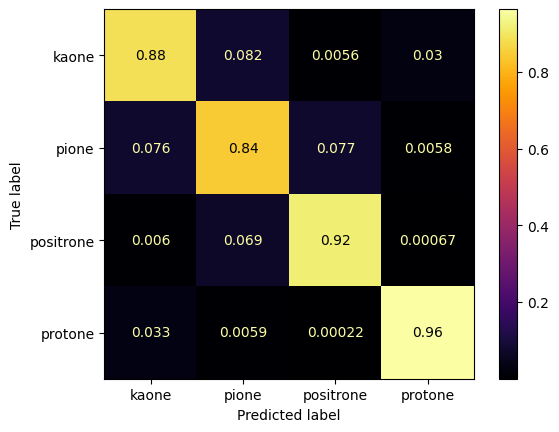

In [126]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, cmap='inferno', normalize = 'pred')

## **Random Forest**

In [127]:
%%time

rf_class = RandomForestClassifier(n_estimators=300, n_jobs=-1)
rf_class.fit(x_train, y_train)
y_pred_rf = rf_class.predict(x_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print('Accuratezza RandomForest\n{:.2%}'.format(rf_accuracy))

Accuratezza RandomForest
93.12%
Wall time: 3.41 s


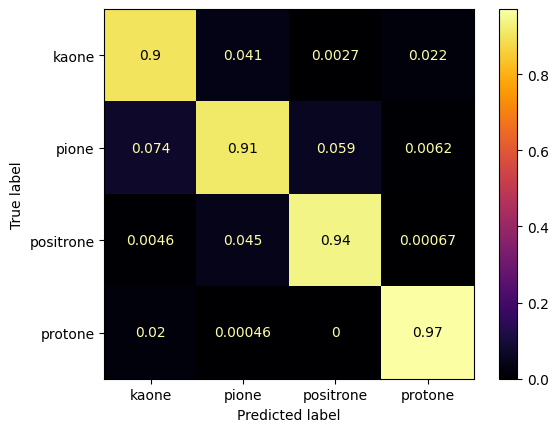

In [128]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='inferno', normalize = 'pred')